In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

<font color='red'>NOTE</font>
---
No set seed in this experiment

# Create the data

n_samples -  (INT) number of points in outer circle and inner circle.

shufflebool - (True, False) Whether to shuffle the samples.

noise - (Float) Standard deviation of Gaussian noise added to the data.

random_state - (INT) Determines random number generation for dataset shuffling and noise.

factor - Scale factor between inner and outer circle in the range [0, 1).

In [2]:
features,_class = make_circles(n_samples=1000, shuffle=True, noise=0.2, random_state=None, factor=0.9)

In [3]:
# convert to a pytorch tensor
data = torch.tensor(features).float()
labels = torch.tensor(_class).float()

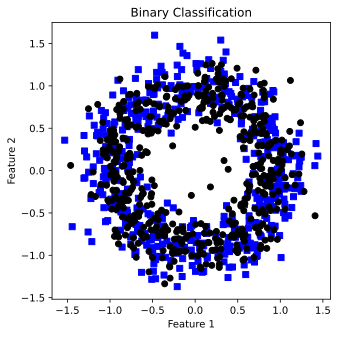

In [4]:
# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("Binary Classification")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Separate the data into DataLoaders

In [5]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 16 #int(train_data.tensors[0].shape[0]/4) -- Hard-coding is better to avoid huge batches!
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??

# Create the model

In [6]:
class binary_class(nn.Module):
    def __init__(self,dropoutRate):
        super().__init__()

        ### layers
        self.input  = nn.Linear(  2,128)
        self.hidden = nn.Linear(128,128)
        self.output = nn.Linear(128, 1)

        # parameters
        self.dr = dropoutRate

    # forward pass
    def forward(self,x):

        # pass the data through the input layer
        x = F.relu( self.input(x) )

        # dropout after input layer
        x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode

        # pass the data through the hidden layer
        x = F.relu( self.hidden(x) )

        # dropout after hidden layer
        x = F.dropout(x,p=self.dr,training=self.training) # training=self.training means to turn off during eval mode

        # output layer
        x = self.output(x)
        # no dropout here!!
        return x

# Functions to create and train the net

In [7]:
def createANewModel(dropoutrate):

  # grab an instance of the model class
  ANN_BINARY = binary_class(dropoutrate)

  # loss function
  lossfunc = nn.BCEWithLogitsLoss()

  # optim
  optim = torch.optim.SGD(ANN_BINARY.parameters(),lr=.002)

  return ANN_BINARY,lossfunc,optim

In [8]:
# train the model

# training parameter
epochs = 1000

# NOTE: this time, the model, lossfunc, and optim are inputs into the function!
def trainTheModel(ANN_BINARY,lossfunc,optim):
    # initialize accuracies as empties (not storing losses here)
    train_accuracy = []
    test_accuracy  = []
    # loop over epochs
    for i in range(epochs):
        # switch training mode on (is this the right place for this code??)
        ANN_BINARY.train()

    # loop over training data batches
    batch_accuracy = []
    for X,y in train_loader:
        y = y.unsqueeze(1) # changed the target tensor size from [16] to [16,1]
        y = y.float() #predictions are in float
        # forward pass and loss
        yHat = ANN_BINARY(X)
        loss = lossfunc(yHat,y)
        # backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        # compute training accuracy just for this batch
        batch_accuracy.append( 100*torch.mean(((yHat>0)==y).float()).item() )
        # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    train_accuracy.append( np.mean(batch_accuracy) )

    # test accuracy
    ANN_BINARY.eval() # switch training off
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = ANN_BINARY(X)
    test_accuracy.append( 100*torch.mean(((yHat>0)==y).float()).item() )
    # function output
    return train_accuracy,test_accuracy


# Experiment Code

In [9]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):
    # create and train the model
    ANN_BINARY,lossfunc,optim = createANewModel(dropoutRates[di])
    train_accuracy,test_accuracy = trainTheModel(ANN_BINARY,lossfunc,optim)

    # store accuracies from last 100 epochs
    results[di,0] = np.mean(train_accuracy[-100:])
    results[di,1] = np.mean(test_accuracy[-100:])


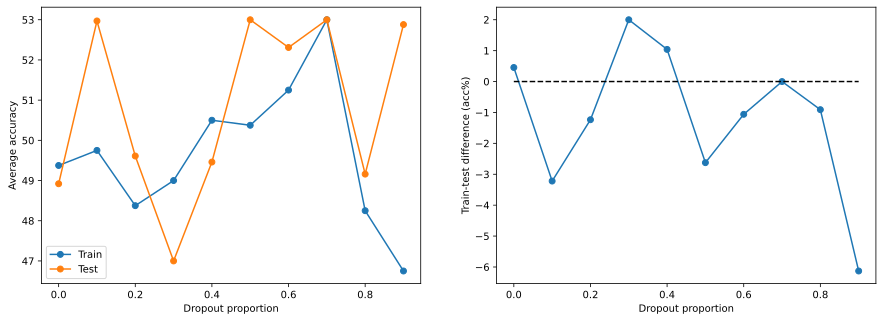

In [10]:
# plot the experiment results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

# Experiment

1. Create an experiment by varying the number of nodes, layers and dropout. Create a bubble graph, with X-axis as the fraction of dropout, y-axis as the number of layers and the size of the circle as the number of nodes. Use the accuracy as legends for the color of the bubbles.

2. Comment out the torch.manual_seed(69) in the experiment code and rerun it five times, does the result change? Why?

#Experiment 1

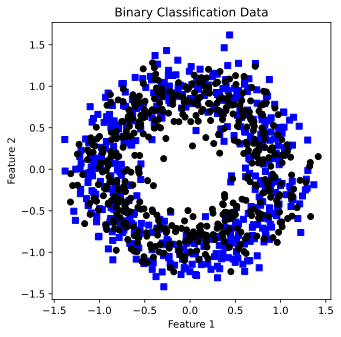

Training: Dropout=0, Layers=1, Nodes=32
Training: Dropout=0, Layers=1, Nodes=64
Training: Dropout=0, Layers=1, Nodes=128
Training: Dropout=0, Layers=1, Nodes=256
Training: Dropout=0, Layers=2, Nodes=32
Training: Dropout=0, Layers=2, Nodes=64
Training: Dropout=0, Layers=2, Nodes=128
Training: Dropout=0, Layers=2, Nodes=256
Training: Dropout=0, Layers=3, Nodes=32
Training: Dropout=0, Layers=3, Nodes=64
Training: Dropout=0, Layers=3, Nodes=128
Training: Dropout=0, Layers=3, Nodes=256
Training: Dropout=0, Layers=4, Nodes=32
Training: Dropout=0, Layers=4, Nodes=64
Training: Dropout=0, Layers=4, Nodes=128
Training: Dropout=0, Layers=4, Nodes=256
Training: Dropout=0.1, Layers=1, Nodes=32
Training: Dropout=0.1, Layers=1, Nodes=64
Training: Dropout=0.1, Layers=1, Nodes=128
Training: Dropout=0.1, Layers=1, Nodes=256
Training: Dropout=0.1, Layers=2, Nodes=32
Training: Dropout=0.1, Layers=2, Nodes=64
Training: Dropout=0.1, Layers=2, Nodes=128
Training: Dropout=0.1, Layers=2, Nodes=256
Training: Dr

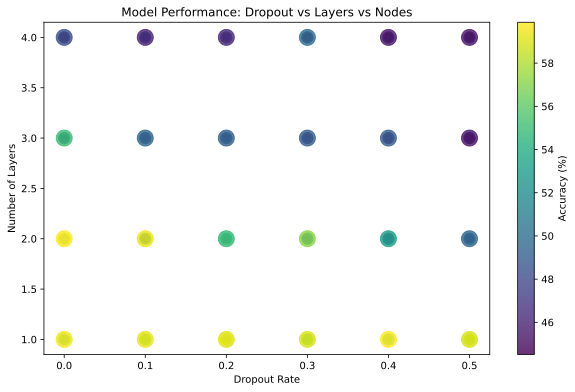

In [11]:
# =============================================================
# 🔹 Import Libraries
# =============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


# =============================================================
# 🔹 Create the Data
# =============================================================
features, _class = make_circles(n_samples=1000, shuffle=True, noise=0.2,
                                random_state=None, factor=0.9)

# convert to PyTorch tensors
data = torch.tensor(features).float()
labels = torch.tensor(_class).float()

# visualize
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bs')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ko')
plt.title("Binary Classification Data")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


# =============================================================
# 🔹 Split into DataLoaders
# =============================================================
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

train_data = TensorDataset(train_data, train_labels)
test_data  = TensorDataset(test_data, test_labels)

batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])


# =============================================================
# 🔹 Define Flexible Model
# =============================================================
class flexible_binary_class(nn.Module):
    def __init__(self, num_layers, num_nodes, dropoutRate):
        super().__init__()
        layers = []

        # Input layer
        layers.append(nn.Linear(2, num_nodes))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropoutRate))

        # Hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(num_nodes, num_nodes))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropoutRate))

        # Output layer
        layers.append(nn.Linear(num_nodes, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


# =============================================================
# 🔹 Helper: Create Model, Loss, Optimizer
# =============================================================
def create_model(num_layers, num_nodes, dropoutRate):
    model = flexible_binary_class(num_layers, num_nodes, dropoutRate)
    lossfunc = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(model.parameters(), lr=0.002)
    return model, lossfunc, optim


# =============================================================
# 🔹 Training Function
# =============================================================
def train_model(model, lossfunc, optim, epochs=300):
    train_accuracy, test_accuracy = [], []

    for epoch in range(epochs):
        model.train()
        batch_accuracy = []

        for X, y in train_loader:
            y = y.unsqueeze(1).float()
            yHat = model(X)
            loss = lossfunc(yHat, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            batch_accuracy.append(100 * torch.mean(((yHat > 0) == y).float()).item())

        train_accuracy.append(np.mean(batch_accuracy))

        # Evaluate
        model.eval()
        X, y = next(iter(test_loader))
        y = y.unsqueeze(1).float()
        yHat = model(X)
        acc = 100 * torch.mean(((yHat > 0) == y).float()).item()
        test_accuracy.append(acc)

    return train_accuracy, test_accuracy


# =============================================================
# 🔹 Run the Experiment
# =============================================================
dropouts = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
layers = [1, 2, 3, 4]
nodes = [32, 64, 128, 256]

results = []

for d in dropouts:
    for l in layers:
        for n in nodes:
            print(f"Training: Dropout={d}, Layers={l}, Nodes={n}")
            model, lossfunc, optim = create_model(l, n, d)
            train_acc, test_acc = train_model(model, lossfunc, optim, epochs=300)
            results.append([d, l, n, np.mean(test_acc[-50:])])  # last 50 epochs


# =============================================================
# 🔹 Convert Results & Plot
# =============================================================
results = np.array(results)
drop_vals = results[:, 0]
layer_vals = results[:, 1]
node_vals = results[:, 2]
acc_vals = results[:, 3]

plt.figure(figsize=(10,6))
sc = plt.scatter(drop_vals, layer_vals, s=node_vals, c=acc_vals, cmap='viridis', alpha=0.8)
plt.colorbar(sc, label='Accuracy (%)')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Layers')
plt.title('Model Performance: Dropout vs Layers vs Nodes')
plt.show()


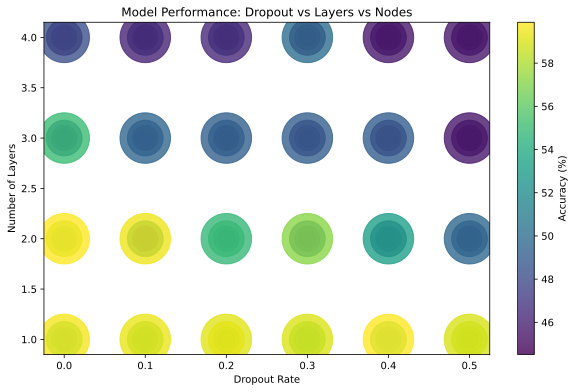

In [12]:
# =============================================================
# 🔹 Convert Results & Plot
# =============================================================
results = np.array(results)
drop_vals = results[:, 0]
layer_vals = results[:, 1]
node_vals = results[:, 2]
acc_vals = results[:, 3]

plt.figure(figsize=(10,6))
sc = plt.scatter(drop_vals, layer_vals, s=node_vals*10, c=acc_vals, cmap='viridis', alpha=0.8)
plt.colorbar(sc, label='Accuracy (%)')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Layers')
plt.title('Model Performance: Dropout vs Layers vs Nodes')
plt.show()


Run 1/5 (no manual seed)

Run 2/5 (no manual seed)

Run 3/5 (no manual seed)

Run 4/5 (no manual seed)

Run 5/5 (no manual seed)


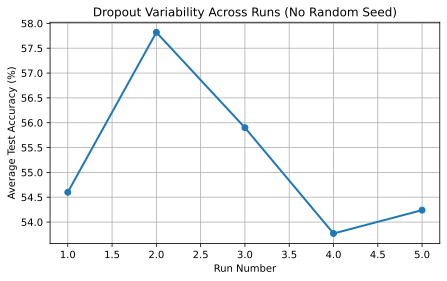

Run 1: Mean Test Accuracy (last 50 epochs) = 54.60%
Run 2: Mean Test Accuracy (last 50 epochs) = 57.82%
Run 3: Mean Test Accuracy (last 50 epochs) = 55.90%
Run 4: Mean Test Accuracy (last 50 epochs) = 53.77%
Run 5: Mean Test Accuracy (last 50 epochs) = 54.24%

Accuracy Variance Across Runs: 2.1318
Accuracy Range: 53.77% – 57.82%


In [13]:
# =============================================================
# 🔹 Import Libraries
# =============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# =============================================================
# 🔹 Create the Data
# =============================================================
features, _class = make_circles(n_samples=1000, shuffle=True, noise=0.2, random_state=None, factor=0.9)

# convert to PyTorch tensors
data = torch.tensor(features).float()
labels = torch.tensor(_class).float()

# =============================================================
# 🔹 Split into DataLoaders
# =============================================================
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

# =============================================================
# 🔹 Model Definition
# =============================================================
class BinaryClassifier(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.input = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128, 1)
        self.dr = dropout_rate

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        x = F.relu(self.hidden(x))
        x = F.dropout(x, p=self.dr, training=self.training)
        return self.output(x)

# =============================================================
# 🔹 Training Function
# =============================================================
def train_model(model, lossfunc, optim, epochs=1000):
    train_acc, test_acc = [], []

    for epoch in range(epochs):
        model.train()
        batch_acc = []
        for X, y in train_loader:
            y = y.unsqueeze(1).float()
            yHat = model(X)
            loss = lossfunc(yHat, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            batch_acc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
        train_acc.append(np.mean(batch_acc))

        # Evaluate
        model.eval()
        X, y = next(iter(test_loader))
        y = y.unsqueeze(1).float()
        yHat = model(X)
        acc = 100 * torch.mean(((yHat > 0) == y).float()).item()
        test_acc.append(acc)

    return train_acc, test_acc

# =============================================================
# 🔹 Experiment: Run Without Setting a Seed (5 Times)
# =============================================================
dropout_rate = 0.3  # moderate dropout
runs = 5
final_results = []

for run in range(runs):
    print(f"\nRun {run+1}/{runs} (no manual seed)")

    # create model
    model = BinaryClassifier(dropout_rate)
    lossfunc = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(model.parameters(), lr=0.002)

    # train
    train_acc, test_acc = train_model(model, lossfunc, optim, epochs=300)
    final_results.append(np.mean(test_acc[-50:]))

# =============================================================
# 🔹 Plot the Results
# =============================================================
plt.figure(figsize=(7,4))
plt.plot(range(1, runs+1), final_results, 'o-', linewidth=2)
plt.title("Dropout Variability Across Runs (No Random Seed)")
plt.xlabel("Run Number")
plt.ylabel("Average Test Accuracy (%)")
plt.grid(True)
plt.show()

# =============================================================
# 🔹 Print Results Summary
# =============================================================
for i, acc in enumerate(final_results):
    print(f"Run {i+1}: Mean Test Accuracy (last 50 epochs) = {acc:.2f}%")

print(f"\nAccuracy Variance Across Runs: {np.var(final_results):.4f}")
print(f"Accuracy Range: {np.min(final_results):.2f}% – {np.max(final_results):.2f}%")
